<div style="text-align: center; font-weight: bold; font-size: 300%">Showcasing SincNet's bandpass filters before and after learning</div>                                                        <br>
<div style="text-align: center; font-weight: bold; font-size: 180%">Is SincNet more efficient without the possibility to learn the bandpass paramters?</div> <br>   
<div style="text-align: center; font-size: 150%">Paris, août 2020</div><br>  
<div style="text-align: center; font-size: 120%">Jean-Charles Layoun</div>

# I- Introduction:

SincNet is the name given by *Mirco Ravanelli and Yoshua Bengio* to their network. This network has for its first 1d convolution layer a bunch of bandpass filters with different frequencies each. Their initialization depends on the input's sampling rate. This notebook aims to visualize the variations of the 1d convolutional layer and mesure its impact on SincNet1D and 2D.

## II- Importing and defining functions for the analysis and selecting Cuda device:

### 1- Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import configparser as ConfigParser
import matplotlib.pyplot as plt
from math import floor

## Local files imports:
from Models import MLP, flip, MainNet
from Models import SincNet as CNN 
from Models import SincNet2D as CNN2D
from read_conf_files import str_to_bool
from utils import Dataset, LoadPrevModel
from training_and_acc_fun import accuracy

### 2- Functions usefull for reading config files:

In [2]:
class Options(object):

    def __init__(self, cfg):
        '''Defines the cfg file'''
        self.cfg = cfg

In [3]:
def read_conf(config_file_path):
    # Removed the possibility of executing with --cfg = path
    # Instead we feed it directly

    # Initializing dummy class with cfg folder path
    options = Options(config_file_path)

    # Reading the config file with config parser
    Config = ConfigParser.ConfigParser()
    Config.read(options.cfg)

    #[data]
    options.tr_lst=Config.get('data', 'tr_lst')
    options.te_lst=Config.get('data', 'te_lst')
    options.lab_dict=Config.get('data', 'lab_dict')
    options.data_folder=Config.get('data', 'data_folder')
    options.output_folder=Config.get('data', 'output_folder')
    options.pt_file=Config.get('data', 'pt_file')

    #[windowing]
    options.fs=Config.get('windowing', 'fs')
    options.cw_len=Config.get('windowing', 'cw_len')
    options.cw_shift=Config.get('windowing', 'cw_shift')

    if('cnn2D' in Config.sections()):
        #[cnn2D]
        options.is_conv2D = True
        options.cnn_N_filt=Config.get('cnn2D', 'cnn_N_filt')
        options.cnn_len_filt_W=Config.get('cnn2D', 'cnn_len_filt_W')
        options.cnn_len_filt_H=Config.get('cnn2D', 'cnn_len_filt_H')
        options.cnn_energy_L=Config.get('cnn2D', 'cnn_energy_L')
        options.cnn_energy_stride=Config.get('cnn2D', 'cnn_energy_stride')
        options.cnn_max_pool_len_W=Config.get('cnn2D', 'cnn_max_pool_len_W')
        options.cnn_max_pool_len_H=Config.get('cnn2D', 'cnn_max_pool_len_H')
        options.cnn_use_laynorm_inp=Config.get('cnn2D', 'cnn_use_laynorm_inp')
        options.cnn_use_batchnorm_inp=Config.get('cnn2D', 'cnn_use_batchnorm_inp')
        options.cnn_use_laynorm=Config.get('cnn2D', 'cnn_use_laynorm')
        options.cnn_use_batchnorm=Config.get('cnn2D', 'cnn_use_batchnorm')
        options.cnn_act=Config.get('cnn2D', 'cnn_act')
        options.cnn_drop=Config.get('cnn2D', 'cnn_drop')
    else:
        #[cnn]
        options.is_conv2D = False
        options.cnn_N_filt=Config.get('cnn', 'cnn_N_filt')
        options.cnn_len_filt=Config.get('cnn', 'cnn_len_filt')
        options.cnn_max_pool_len=Config.get('cnn', 'cnn_max_pool_len')
        options.cnn_use_laynorm_inp=Config.get('cnn', 'cnn_use_laynorm_inp')
        options.cnn_use_batchnorm_inp=Config.get('cnn', 'cnn_use_batchnorm_inp')
        options.cnn_use_laynorm=Config.get('cnn', 'cnn_use_laynorm')
        options.cnn_use_batchnorm=Config.get('cnn', 'cnn_use_batchnorm')
        options.cnn_act=Config.get('cnn', 'cnn_act')
        options.cnn_drop=Config.get('cnn', 'cnn_drop')


    #[dnn]
    options.fc_lay=Config.get('dnn', 'fc_lay')
    options.fc_drop=Config.get('dnn', 'fc_drop')
    options.fc_use_laynorm_inp=Config.get('dnn', 'fc_use_laynorm_inp')
    options.fc_use_batchnorm_inp=Config.get('dnn', 'fc_use_batchnorm_inp')
    options.fc_use_batchnorm=Config.get('dnn', 'fc_use_batchnorm')
    options.fc_use_laynorm=Config.get('dnn', 'fc_use_laynorm')
    options.fc_act=Config.get('dnn', 'fc_act')

    #[class]
    options.class_lay=Config.get('class', 'class_lay')
    options.class_drop=Config.get('class', 'class_drop')
    options.class_use_laynorm_inp=Config.get('class', 'class_use_laynorm_inp')
    options.class_use_batchnorm_inp=Config.get('class', 'class_use_batchnorm_inp')
    options.class_use_batchnorm=Config.get('class', 'class_use_batchnorm')
    options.class_use_laynorm=Config.get('class', 'class_use_laynorm')
    options.class_act=Config.get('class', 'class_act')


    #[optimization]
    if('optimization' in Config.sections()):
        options.lr=Config.get('optimization', 'lr')

        ## use_scheduler:
        if 'use_scheduler' in Config['optimization']:
            options.use_scheduler=Config.get('optimization', 'use_scheduler')
        else:
            print("You did not specify the value of `use_scheduler`, it is set to False.")
            options.use_scheduler='False'

        ## scheduler_patience:
        if 'scheduler_patience' in Config['optimization']:
            options.scheduler_patience=Config.get('optimization', 'scheduler_patience')
        else:
            options.scheduler_patience=2
            print("You did not specify the value of `scheduler_patience`, it is set to {}.".format(options.scheduler_patience))

        ## scheduler_factor:
        if 'scheduler_factor' in Config['optimization']:
            options.scheduler_factor=Config.get('optimization', 'scheduler_factor')
        else:
            options.scheduler_factor=0.5
            print("You did not specify the value of `scheduler_factor`, it is set to {}.".format(options.scheduler_factor))


        options.batch_size=Config.get('optimization', 'batch_size')

        ## Batch_dev:
        if 'Batch_dev' in Config['optimization']:
            options.Batch_dev=Config.get('optimization', 'Batch_dev')
        else:
            options.Batch_dev=32
            print("You did not specify the value of `Batch_dev`, it is set to {}.".format(options.Batch_dev))

        ## patience:
        if 'patience' in Config['optimization']:
            options.patience=Config.get('optimization', 'patience')
        else:
            print("You did not specify the value of `patience`, it is set to 7.")
            options.patience=7

        options.N_epochs=Config.get('optimization', 'N_epochs')
        options.N_batches=Config.get('optimization', 'N_batches')
        options.N_eval_epoch=Config.get('optimization', 'N_eval_epoch')
        
        ## train_acc_period:
        if 'train_acc_period' in Config['optimization']:
                options.train_acc_period=Config.get('optimization', 'train_acc_period')
        else:
            print("You did not specify the value of `train_acc_period`, it is set to 5.")
            options.train_acc_period=5
        
        ## fact_amp:        
        if 'fact_amp' in Config['optimization']:
                options.fact_amp=Config.get('optimization', 'fact_amp')
        else:
            options.fact_amp=0.2
            print("You did not specify the value of `fact_amp`, it is set to {}.".format(options.fact_amp))
        
        ## use_mixup:
        if 'use_mixup' in Config['optimization']:
            options.use_mixup=Config.get('optimization', 'use_mixup')
        else:
            print("You did not specify the value of `use_mixup`, it is set to False.")
            options.use_mixup='False'
        
        ## mixup_batch_prop:        
        if 'mixup_batch_prop' in Config['optimization']:
            options.mixup_batch_prop=Config.get('optimization', 'mixup_batch_prop')
        else:
            options.mixup_batch_prop=float(1.0) if options.use_mixup=='True' else float(0.0)
            print("You did not specify the value of `mixup_batch_prop`, it is set to {}%.".format(options.mixup_batch_prop*100))
        
        ## beta_coef:
        if 'beta_coef' in Config['optimization']:
            options.beta_coef=Config.get('optimization', 'beta_coef')
        else:
            print("You did not specify the value of `beta_coef`, it is set to 0.4.")
            options.beta_coef=0.4
        
        ## same_classes:        
        if 'same_classes' in Config['optimization']:
            options.same_classes=Config.get('optimization', 'same_classes')
        else:
            options.same_classes='False'
            print("You did not specify the value of `same_classes`, it is set to {}.".format(options.same_classes))
            if("True" in options.use_mixup):
                print("Warning: you are using mixup but you did not mention which type in config file. \n"+
                    "By default it will be set to False. You are advised to add a same_class attribute to your cfg file and set it to True or False.")    

            
        options.seed=Config.get('optimization', 'seed')
    else:
        print("Error, you did not specify optimization parameters in your cfg. Consequently, the code won't run...")

    #[Misc]
    ## In SincNet, we must always use SincConv_fast, it is the whole point of SincNet. But, just for testing, we added the possibility to deactivate it. 
    ## This is why we do not prompt the user if he does not have a `Misc`section.
    options.use_SincConv_fast='True'
    if('Misc' in Config.sections()):
        ## use_SincConv_fast:        
        if 'use_SincConv_fast' in Config['Misc']:
            options.use_SincConv_fast=Config.get('Misc', 'use_SincConv_fast')
        else:
            print("You did not specify the value of `use_SincConv_fast`, but don't worry, it is set to {}.".format(options.use_SincConv_fast))
        

    return options


### 3- Selecting cuda device:

In [4]:
## Setting cuda Device
print("Selecting Cuda device... \t\t", end="")
Desired_cuda_device_number = int(0)

if torch.cuda.is_available(): # we'll use cuda
    device = "cuda:"+str(Desired_cuda_device_number)
    torch.cuda.set_device(device)
    if(torch.cuda.current_device() == Desired_cuda_device_number and torch.cuda.is_available()):
        print("Cuda device {} was selected successfully!".format(Desired_cuda_device_number))
    else:
        print("Cuda was not selected successfully...")
else:
    print("Cuda device(s) is(are) not available.")

Selecting Cuda device... 		Cuda device 0 was selected successfully!


### 4- Functions for plotting bandpass filters:

In [5]:
def PerfectBandpassFilter(f, f1, f2):
    """Function that returns the normalized gain of a bandpass.
    
    Args:
        act_type (list): A list of frequencies in (Hz).

    Returns:
        (list): Returns the values of a BandpassFilter according to the given frequencies (f).
    """
    ## Creates list of booleans:
    inf = f1 <= f
    sup = f  <= f2
    
    res = [1 if inf[i] and sup[i] else 0 for i in range (len(f))]
    
    return res


def PlotFilters(f_low, f_high, SincNet_type = "Freezed", f_low2=None, f_high2=None, SincNet_type2 = "Normal"):
    """Function that plots perfect bandpass filters.
    
    Args:
        f_low (list): A list of lower cutoff frequencies in (Hz).
        f_high (list): A list of upper cutoff frequencies in (Hz).
        SincNet_type (str, optional): String that is used to display the origin of those bandpass filters.
        f_low (list, optional): A second list of lower cutoff frequencies in (Hz).
        f_high (list, optional): A second list of upper cutoff frequencies in (Hz).
        SincNet_type (str, optional): String that is used to display the origin of the second batch of bandpass filters.
    """
    if len(f_low) != len(f_high):
        print("Error: The number of low frequencies is not equal to the number of high frequencies.")
        return -1
    
    elif(f_low2 is not None):
        if len(f_low2) != len(f_high):
            print("Error: The number of low frequencies2 is not equal to the number of high frequencies1.")
            return -2
        
        elif len(f_low2) != len(f_high2):
            print("Error: The number of low frequencies2 is not equal to the number of high frequencies2.")
            return -3
    
    ## interval shift:
    shift = 400 if f_low2 is None else max(max(abs(f_high2-f_high)), max(abs(f_low2-f_low))) + 100

    ## Parameters for plot function:
    N_filters = len(f_low)
    N_column  = 3

    fig, ax = plt.subplots(int(np.ceil(N_filters/N_column)), N_column, sharey=True, figsize=(65, 30))   

    for i in range(N_filters):

        ## Position in the axes grid:
        axi, axj = int(i/N_column), i%N_column
        
        ## Frequencies of the Currente bandpass:
        f_low_i, f_high_i = f_low[i], f_high[i]
        
        ## Frequencies plotted:
        freqs = np.linspace(f_low_i - shift, f_high_i + shift, 1000)
        
        # Here, we control the values of the ordinate and abscissa with the variable extent:
        pos = ax[axi][axj].plot(freqs, PerfectBandpassFilter(freqs, f_low_i, f_high_i), label="bandpass number {}".format(i+1))

        ## Plots second filter if needed:
        if(f_low2 is not None):
            f_low_i2, f_high_i2 = f_low2[i], f_high2[i]
            ax[axi][axj].plot(freqs, PerfectBandpassFilter(freqs, f_low_i2, f_high_i2), label="bandpass2 number {}".format(i+1))

        
        # Plots the dotted line to mark half of the energy:
        ax[axi][axj].plot(freqs, [np.sqrt(0.5)]*len(freqs), '--', label='sqrt(0.5)')
        
        # Regular labels for bandpass filters:
        ax[axi][axj].set_xlabel('Frequency (Hz)')
        ax[axi][axj].set_ylabel('Gain')
        ax[axi][axj].legend(loc='best')


    # Places the spectrograms next to each other:
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)
    
    if(f_low2 is not None):
        title = "Representation of each bandpass filters of SincNet {0} and {1}:".format(SincNet_type, SincNet_type2)
    else:
        title = "Representation of each bandpass filters of SincNet {0}:".format(SincNet_type)
    
    # Writes the title:
    fig.suptitle(title, fontsize=25, y=1.0)

    plt.show()
    
def PlotFiltersAndAudioOutput(audios, f_low, f_high, SincNet_type = "Freezed"):
    """Function that plots perfect bandpass filters.
    
    Args:
        audios(torch.tensor): A minibatch of three audio tensors.
        f_low (list): A list of lower cutoff frequencies in (Hz).
        f_high (list): A list of upper cutoff frequencies in (Hz).
        SincNet_type (str, optional): String that is used to display the origin of those bandpass filters.
    """
    if len(f_low) != len(f_high):
        print("Error: The number of low frequencies is not equal to the number of high frequencies.")
        return -1
    
    elif(f_low > 3):
            print("Error: The number of bandpasses must not be greater than 3.")
    

    fig, ax = plt.subplots(2, 3, sharey=True, figsize=(65, 30))   


    ## interval shift:
    shift = 400 if f_low2 is None else max(max(abs(f_high2-f_high)), max(abs(f_low2-f_low))) + 100

    ## Plot filters
    for i in range(len(f_low)):        
        ## Frequencies of the Currente bandpass:
        f_low_i, f_high_i = f_low[i], f_high[i]
        
        ## Frequencies plotted:
        freqs = np.linspace(f_low_i - shift, f_high_i + shift, 1000)
        
        # Here, we control the values of the ordinate and abscissa with the variable extent:
        pos = ax[1][i].plot(freqs, PerfectBandpassFilter(freqs, f_low_i, f_high_i), label="bandpass number {}".format(i+1))

        ## Plots second filter if needed:
        if(f_low2 is not None):
            f_low_i2, f_high_i2 = f_low2[i], f_high2[i]
            ax[axi][axj].plot(freqs, PerfectBandpassFilter(freqs, f_low_i2, f_high_i2), label="bandpass2 number {}".format(i+1))

        
        # Plots the dotted line to mark half of the energy:
        ax[axi][axj].plot(freqs, [np.sqrt(0.5)]*len(freqs), '--', label='sqrt(0.5)')
        
        # Regular labels for bandpass filters:
        ax[axi][axj].set_xlabel('Frequency (Hz)')
        ax[axi][axj].set_ylabel('Gain')
        ax[axi][axj].legend(loc='best')


    # Places the spectrograms next to each other:
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)
    
    if(f_low2 is not None):
        title = "Representation of each bandpass filters of SincNet {0} and {1}:".format(SincNet_type, SincNet_type2)
    else:
        title = "Representation of each bandpass filters of SincNet {0}:".format(SincNet_type)
    
    # Writes the title:
    fig.suptitle(title, fontsize=25, y=1.0)

    plt.show()

### 5- Function that computes mel spectrogram:

In [6]:
from nnAudio import Spectrogram

In [7]:
def ComputeSpectrogram(audio, sampling_rate, device = torch.cuda.current_device(), is_Mel = False):
    ##  Initializing the spectrogram
    if is_Mel:
        spec_layer = Spectrogram.MelSpectrogram(n_fft=2048, n_mels=80, hop_length=512,#n_mels=80 in order to be the same with SincNet 
                              window='hann', center=True, pad_mode='reflect', 
                              sr = sampling_rate, device=device, trainable_mel=False, trainable_STFT=False) # Initializing the model with device='cuda:0'
    
    else:
        spec_layer = Spectrogram.STFT(n_fft=2048, freq_bins=None, hop_length=512, 
                      window='hann', freq_scale='linear', center=True, pad_mode='reflect', 
                      sr = sampling_rate, device=device, trainable=False) # Initializing the model with device='cuda:0'
    
    return spec_layer(audio)

### 6- Functions for plotting signals and spectrograms:

In [8]:
def FlatteningAudio(audio, mean = False):
    """Function that takes the output of the SincNet bandpasses and reshapes it to its original audio form.
    
    Args:
        audio (torch.tensor): Is the output of the SincNet bandpasses after it was fed the original audio.
        mean (bool, optional): Indicates if user wishes to return the mean, if so it must be set to true. Defaults to False.
    
    Returns:
        (torch.tensor): Returns the audio in its original form. 
    """
    audio = audio.view(80, -1)
    audio = audio.sum(0)
    audio = audio.view(-1)
    
    if mean:
        audio /= 80
    
    return audio

# Fonction that changes the scale of the power:
def tensorLogScale(tensor):
    """Fonction that converts tensors to log scale.
    
    Args:
        tensor(torch.tensor): Input tensor.
        
    Returns:
        (torch.tensor): Returns tensor in log scale.
    """
    # Constant that translates all values to 10^-3
    eps = 1e-3

    # log(eps + pow):
    return (eps + tensor).log10()


# @specType is a string
def PrintAudioAndSpectrogram(audio, title, sampling_rate, is_Mel = False):
    fig, ax = plt.subplots(1,2, figsize=(20,8))
    
    
    add_subtitle = "Mel " if is_Mel else ""
    # Subplot titles
    labelsForSubplots = ["Audio signal", "Log {}Spectrogram".format(add_subtitle)]
        

    for i, lab in enumerate(labelsForSubplots):
        
        if i==0:
            T = audio.size(0)/ sampling_rate
            t = np.linspace(0, T, audio.size(0))
            ax[i].plot(t, audio.cpu().detach().numpy(), label='Filtered signal')
            ax[i].title.set_text(lab)
            ax[i].set_xlabel('time (seconds)')
            ax[i].legend(loc='upper left')

            
        elif i==1:
            # Computing the mel spectrogram:
            spec = ComputeSpectrogram(audio, sampling_rate, device = torch.cuda.current_device())
            
            # log(eps + pow):
            logPow = tensorLogScale(spec.cpu().detach())[0]

            # Here, we control the values of the ordinate and abscissa with the variable extent:
            pos = ax[i].imshow(logPow, origin='lower', cmap='jet', aspect='auto')
            ax[i].title.set_text(lab)
            ax[i].set_xlabel('Time frames')
            ax[i].set_ylabel('Frequency [Hz]')

            # Plot colorbar
            fig.colorbar(pos, ax=ax[i])

    fig.suptitle("Representation of an audio Signal and Spectrogram {}:".format(title), fontsize=20, y=1)

    plt.show()   

## III- Influence of learning bandpoass filters on SincNet1D:

### 1- Choosing the SincNet1D config file of the network with best results:

In [9]:
# Config path location
config_file_path = "cfg/SincNet_DCASE_CNNLay4_Rand0PreEnergyWindow800_Scheduler_PReLu_Drop30.cfg"

# Reading cfg file and storing its parameters into options :
options=read_conf(config_file_path)

You did not specify the value of `fact_amp`, it is set to 0.2.
You did not specify the value of `mixup_batch_prop`, it is set to 0.0%.


### 2- Reading Config File:

In [13]:
## Architecture of the file:
#[data]
pt_file=options.pt_file
output_folder=options.output_folder

#[windowing]
fs=int(options.fs)
cw_len=int(options.cw_len)
cw_shift=int(options.cw_shift)

#[cnn2D/1D]
is_conv2D = options.is_conv2D
conv_type = '2D' if is_conv2D else '1D'
print("The file contains the config of a {} convolutional network.".format(conv_type))
if is_conv2D:
    #[cnn2D]
    cnn_N_filt=list(map(int, options.cnn_N_filt.split(',')))
    cnn_len_filt_W=list(map(int, options.cnn_len_filt_W.split(',')))
    cnn_len_filt_H=list(map(int, options.cnn_len_filt_H.split(',')))
    cnn_energy_L=int(options.cnn_energy_L)
    cnn_energy_stride=int(options.cnn_energy_stride)
    cnn_max_pool_len_W=list(map(int, options.cnn_max_pool_len_W.split(',')))
    cnn_max_pool_len_H=list(map(int, options.cnn_max_pool_len_H.split(',')))
else:
    #[cnn]
    cnn_N_filt=list(map(int, options.cnn_N_filt.split(',')))
    cnn_len_filt=list(map(int, options.cnn_len_filt.split(',')))
    cnn_max_pool_len=list(map(int, options.cnn_max_pool_len.split(',')))

cnn_use_laynorm_inp=str_to_bool(options.cnn_use_laynorm_inp)
cnn_use_batchnorm_inp=str_to_bool(options.cnn_use_batchnorm_inp)
cnn_use_laynorm=list(map(str_to_bool, options.cnn_use_laynorm.split(',')))
cnn_use_batchnorm=list(map(str_to_bool, options.cnn_use_batchnorm.split(',')))
cnn_act=list(map(str, options.cnn_act.split(',')))
cnn_drop=list(map(float, options.cnn_drop.split(',')))



#[dnn]
fc_lay=list(map(int, options.fc_lay.split(',')))
fc_drop=list(map(float, options.fc_drop.split(',')))
fc_use_laynorm_inp=str_to_bool(options.fc_use_laynorm_inp)
fc_use_batchnorm_inp=str_to_bool(options.fc_use_batchnorm_inp)
fc_use_batchnorm=list(map(str_to_bool, options.fc_use_batchnorm.split(',')))
fc_use_laynorm=list(map(str_to_bool, options.fc_use_laynorm.split(',')))
fc_act=list(map(str, options.fc_act.split(',')))

#[class]
class_lay=list(map(int, options.class_lay.split(',')))
class_drop=list(map(float, options.class_drop.split(',')))
class_use_laynorm_inp=str_to_bool(options.class_use_laynorm_inp)
class_use_batchnorm_inp=str_to_bool(options.class_use_batchnorm_inp)
class_use_batchnorm=list(map(str_to_bool, options.class_use_batchnorm.split(',')))
class_use_laynorm=list(map(str_to_bool, options.class_use_laynorm.split(',')))
class_act=list(map(str, options.class_act.split(',')))

#[optimization]
Batch_dev=int(options.Batch_dev)
N_eval_epoch=int(options.N_eval_epoch)

#[Misc]
use_SincConv_fast = str_to_bool(options.use_SincConv_fast)


# Converting context and shift in samples
wlen=int(fs*cw_len/1000.00)
wshift=int(fs*cw_shift/1000.00)


# loss functions
cost = nn.NLLLoss()


The file contains the config of a 1D convolutional network.


### 3- Creating the architecture for networks and initializing them:

In [14]:
## <!>------------------- Initializing the Networks with .cfg options -------------------<!> ##

print("Initializing the Networks... \t\t", end="")

# Feature extractor CNN
if is_conv2D:
    CNN_arch = {'input_dim': wlen,
            'fs': fs,
            'cnn_N_filt': cnn_N_filt,
            'cnn_len_filt_W': cnn_len_filt_W,
            'cnn_len_filt_H': cnn_len_filt_H,
            'cnn_energy_L': cnn_energy_L,
            'cnn_energy_stride': cnn_energy_stride,
            'cnn_max_pool_len_W': cnn_max_pool_len_W,
            'cnn_max_pool_len_H': cnn_max_pool_len_H,
            'cnn_use_laynorm_inp': cnn_use_laynorm_inp,
            'cnn_use_batchnorm_inp': cnn_use_batchnorm_inp,
            'cnn_use_laynorm':cnn_use_laynorm,
            'cnn_use_batchnorm':cnn_use_batchnorm,
            'cnn_act': cnn_act,
            'cnn_drop':cnn_drop,  
            'use_SincConv_fast': use_SincConv_fast,
            }
else:
    CNN_arch = {'input_dim': wlen,
            'fs': fs,
            'cnn_N_filt': cnn_N_filt,
            'cnn_len_filt': cnn_len_filt,
            'cnn_max_pool_len':cnn_max_pool_len,
            'cnn_use_laynorm_inp': cnn_use_laynorm_inp,
            'cnn_use_batchnorm_inp': cnn_use_batchnorm_inp,
            'cnn_use_laynorm':cnn_use_laynorm,
            'cnn_use_batchnorm':cnn_use_batchnorm,
            'cnn_act': cnn_act,
            'cnn_drop':cnn_drop,
            'use_SincConv_fast': use_SincConv_fast,
            }

## Initializes SincNet:
CNN_net=CNN2D(CNN_arch) if is_conv2D else CNN(CNN_arch)
CNN_net.cuda()


## First DNN, follows the config from the section [dnn] in .cfg file
DNN1_arch = {'input_dim': CNN_net.out_dim,
          'fc_lay': fc_lay,
          'fc_drop': fc_drop, 
          'fc_use_batchnorm': fc_use_batchnorm,
          'fc_use_laynorm': fc_use_laynorm,
          'fc_use_laynorm_inp': fc_use_laynorm_inp,
          'fc_use_batchnorm_inp':fc_use_batchnorm_inp,
          'fc_act': fc_act,
          }

DNN1_net=MLP(DNN1_arch)
DNN1_net.cuda()

## Last trainable layer, has softmax as activation function see section [class] in .cfg
DNN2_arch = {'input_dim':fc_lay[-1] ,
          'fc_lay': class_lay,
          'fc_drop': class_drop, 
          'fc_use_batchnorm': class_use_batchnorm,
          'fc_use_laynorm': class_use_laynorm,
          'fc_use_laynorm_inp': class_use_laynorm_inp,
          'fc_use_batchnorm_inp':class_use_batchnorm_inp,
          'fc_act': class_act,
          }


DNN2_net=MLP(DNN2_arch)
DNN2_net.cuda()

## Network that regroups all 3 networks:
Main_net = MainNet(CNN_net, DNN1_net, DNN2_net)
Main_net.cuda()


print("Initialization done!")


Initializing the Networks... 		Initialization done!


### 4- Loading audio tensor:

In [15]:
audio_tensor = torch.load("Tensor_for_notebook/00ad7068.pt")


sampling_rate = 32000
wlen          = int(sampling_rate *800 /1000)

audio_tensor = audio_tensor.cuda()

## Stores the lenght of the signal:
snt_len = audio_tensor.shape[0]

snt_beg = 0 if snt_len-wlen-1 in (0, -1) else np.random.randint(snt_len-wlen-1)
snt_end = snt_beg + wlen

## Creates the random chunk:
audio_tensor = audio_tensor[snt_beg:snt_end]

audio_tensor = audio_tensor.view(1,1,wlen)

### 5- Loading the networks:

#### a- Network Freezed Sinc filters:

##### Loading the net:

In [16]:
model_file_name       = "CNNlay4_Rand0PreEnergy1000ms_Scheduler_Window800ms_PReLu_Drop30_FreezeSincNet"
Models_file_extension = ".pkl" if pt_file == 'none' else pt_file.split(".")[1]
previous_model_path   = output_folder+ '/' + model_file_name if pt_file == 'none' else pt_file.split(".")[0]
inTheSameFile         = False## To change depending on versions
sincnet_version       = 2## To change depending on versions


## Adapts the paths if it is the version 1 of SincNet:
if(sincnet_version == 1):
    previous_model_path = "../SincNet_DCASE/" + previous_model_path



## Loading previously trained model if needed:
#Function was modified especially for .py folders:
Main_net_freezed, _, _, _, _, _ = LoadPrevModel(Main_net, CNN_net, DNN1_net, DNN2_net, 
                                                previous_model_path, 
                                                Models_file_extension, 
                                                Load= True, 
                                                inSameFile = inTheSameFile,
                                                test_acc_period = N_eval_epoch,
                                                at_epoch = 0,
                                                evalMode = True)

## Computing audio tensor after freezed bandpasses:
with torch.no_grad():
    audio_tensor_freezed = Main_net_freezed.CNN_net.conv[0](audio_tensor)

Models from exp/SincNet_DCASE_v2.0/CNNlay4_Rand0PreEnergy1000ms_Scheduler_Window800ms_PReLu_Drop30/CNNlay4_Rand0PreEnergy1000ms_Scheduler_Window800ms_PReLu_Drop30_FreezeSincNet were loaded successfully!
Model reached a minimum loss of 1.168097 after 165 epochs.


##### Showing the unchanged filters:

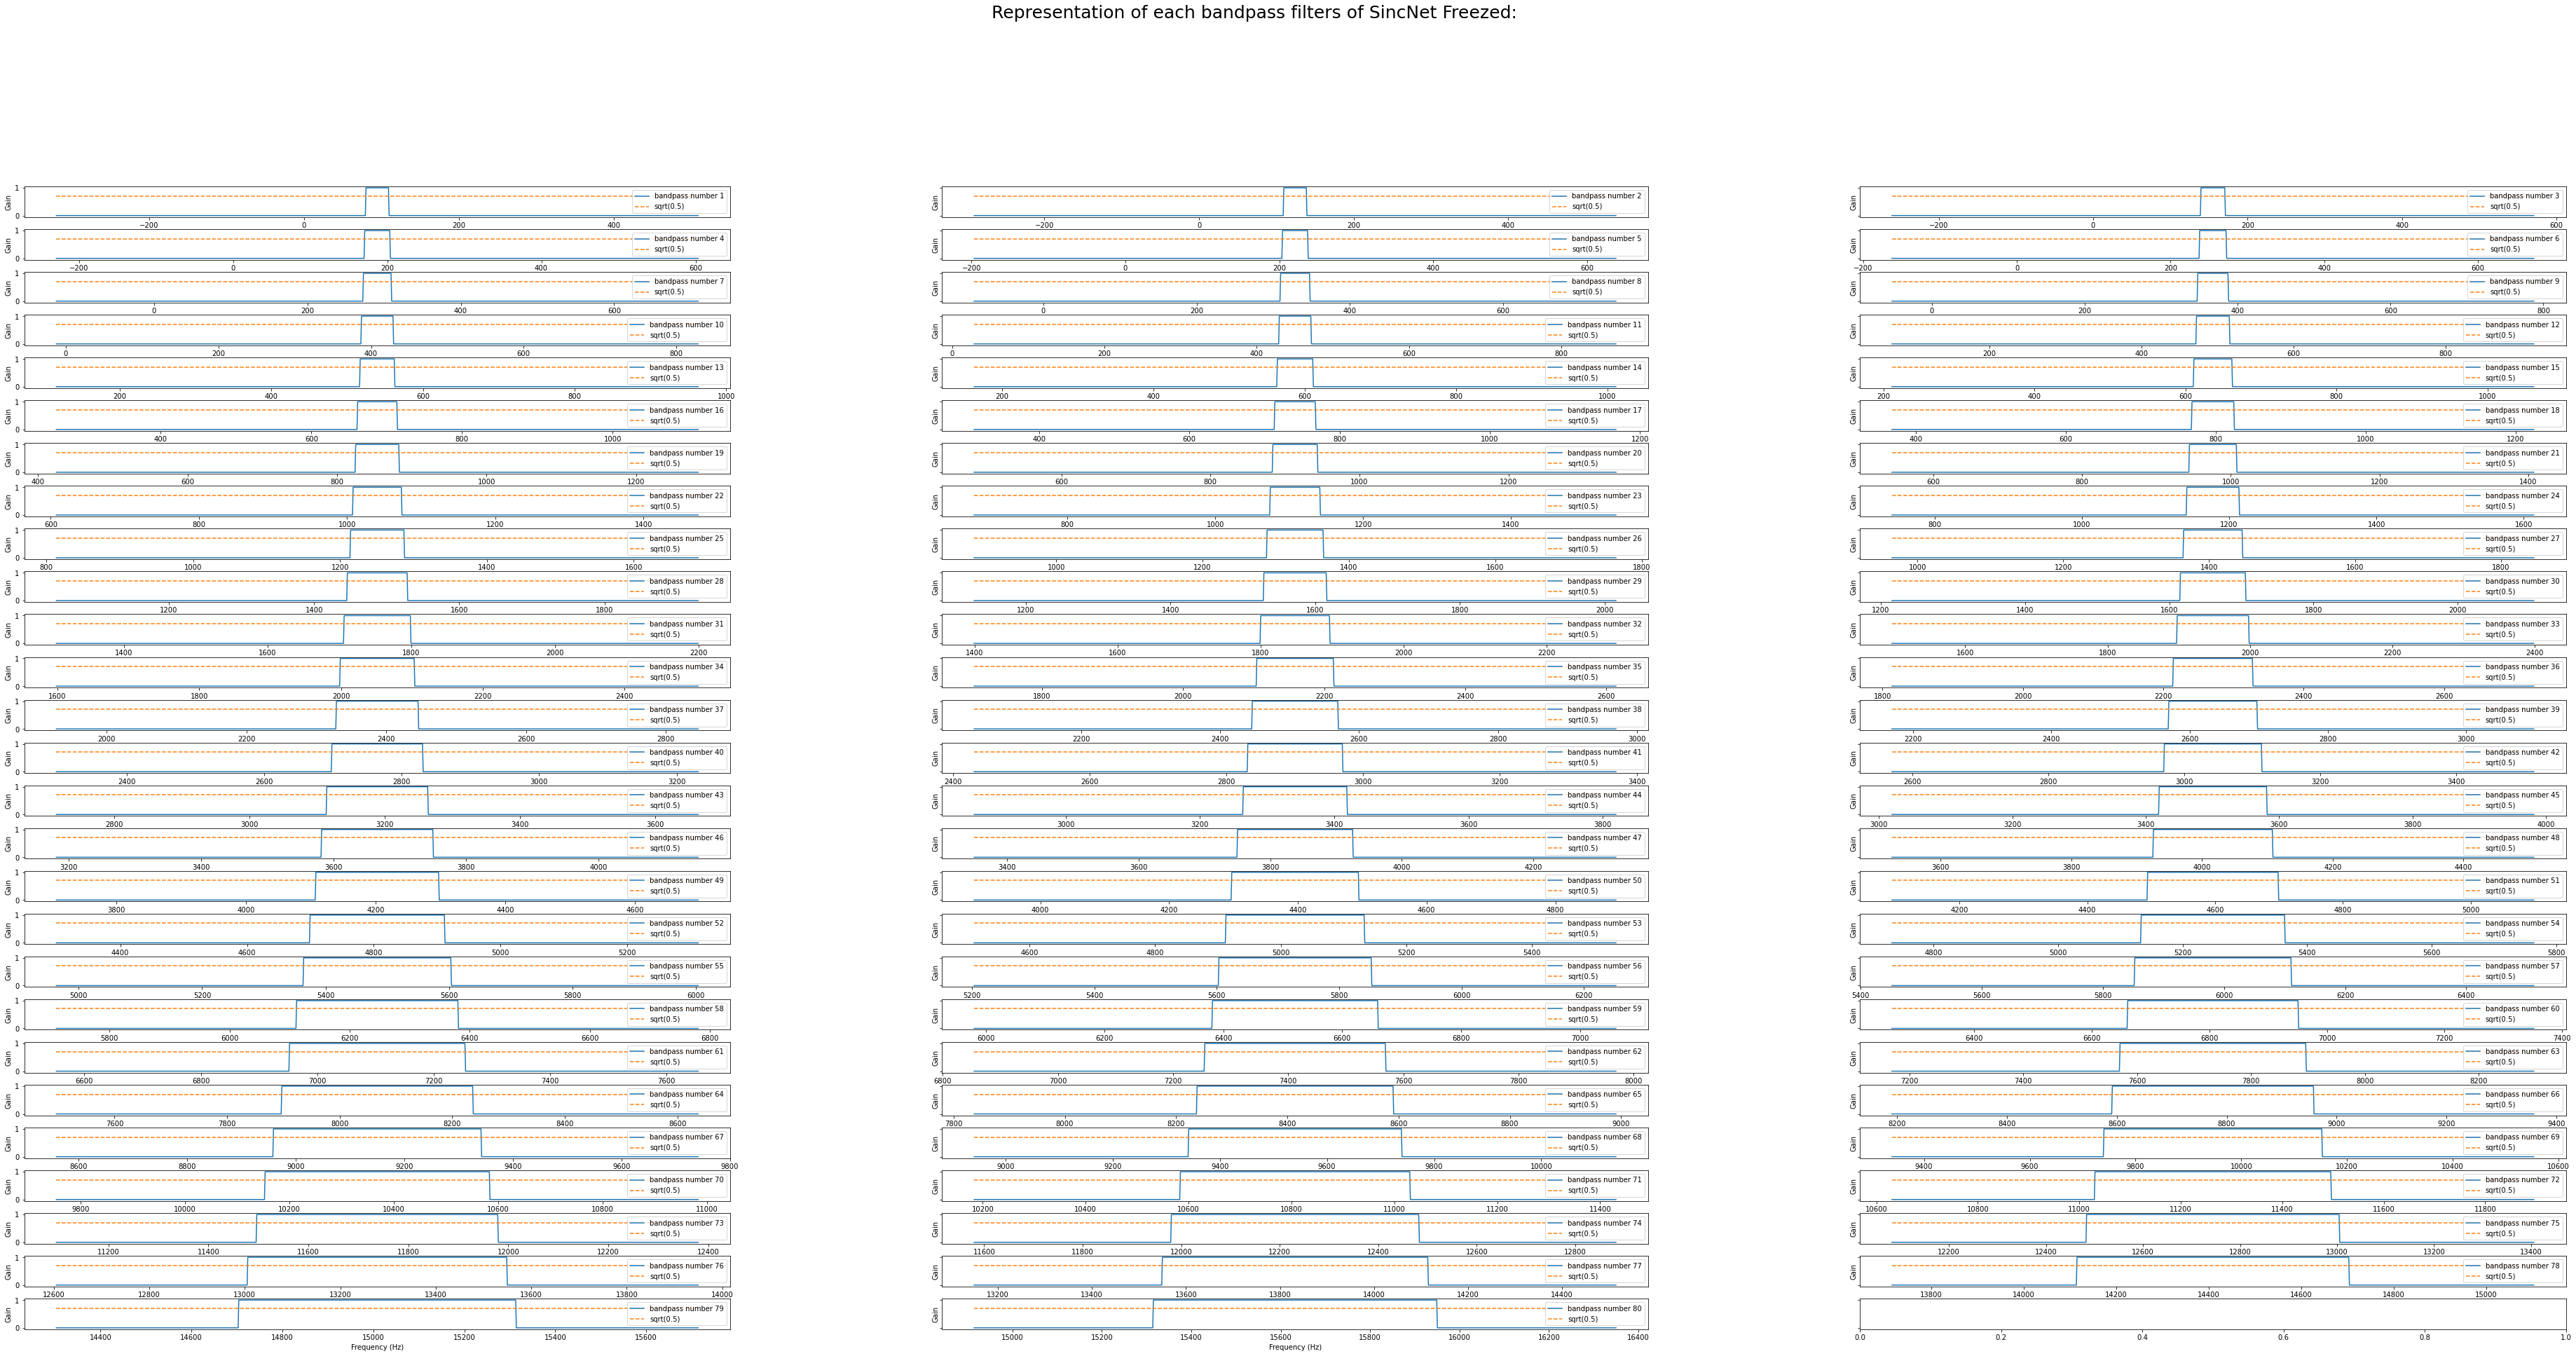

In [17]:
low_freq = Main_net_freezed.CNN_net.conv[0].min_low_hz + Main_net_freezed.CNN_net.conv[0].low_hz_.cpu().detach().numpy()
high_freq = low_freq + Main_net_freezed.CNN_net.conv[0].band_hz_.cpu().detach().numpy()

PlotFilters(low_freq, high_freq)

#### b- Normal SincNet:

##### Loading the net:

In [18]:
model_file_name       = "CNNlay4_Rand0PreEnergy1000ms_Scheduler_Window800ms_PReLu_Drop30_normalSincNet"
Models_file_extension = ".pkl" if pt_file == 'none' else pt_file.split(".")[1]
previous_model_path   = output_folder+ '/' + model_file_name if pt_file == 'none' else pt_file.split(".")[0]
inTheSameFile         = False## To change depending on versions
sincnet_version       = 2## To change depending on versions


## Adapts the paths if it is the version 1 of SincNet:
if(sincnet_version == 1):
    previous_model_path = "../SincNet_DCASE/" + previous_model_path



## Loading previously trained model if needed:
#Function was modified especially for .py folders:
Main_net_normal, _, _, _, _, _ = LoadPrevModel(Main_net, CNN_net, DNN1_net, DNN2_net, 
                                                previous_model_path, 
                                                Models_file_extension, 
                                                Load= True, 
                                                inSameFile = inTheSameFile,
                                                test_acc_period = N_eval_epoch,
                                                at_epoch = 0,
                                                evalMode = True)

## Computing audio tensor after normal bandpasses:
with torch.no_grad():
    audio_tensor_normal = Main_net_freezed.CNN_net.conv[0](audio_tensor)

Models from exp/SincNet_DCASE_v2.0/CNNlay4_Rand0PreEnergy1000ms_Scheduler_Window800ms_PReLu_Drop30/CNNlay4_Rand0PreEnergy1000ms_Scheduler_Window800ms_PReLu_Drop30_normalSincNet were loaded successfully!
Model reached a minimum loss of 1.139176 after 235 epochs.


##### Showing the variation:

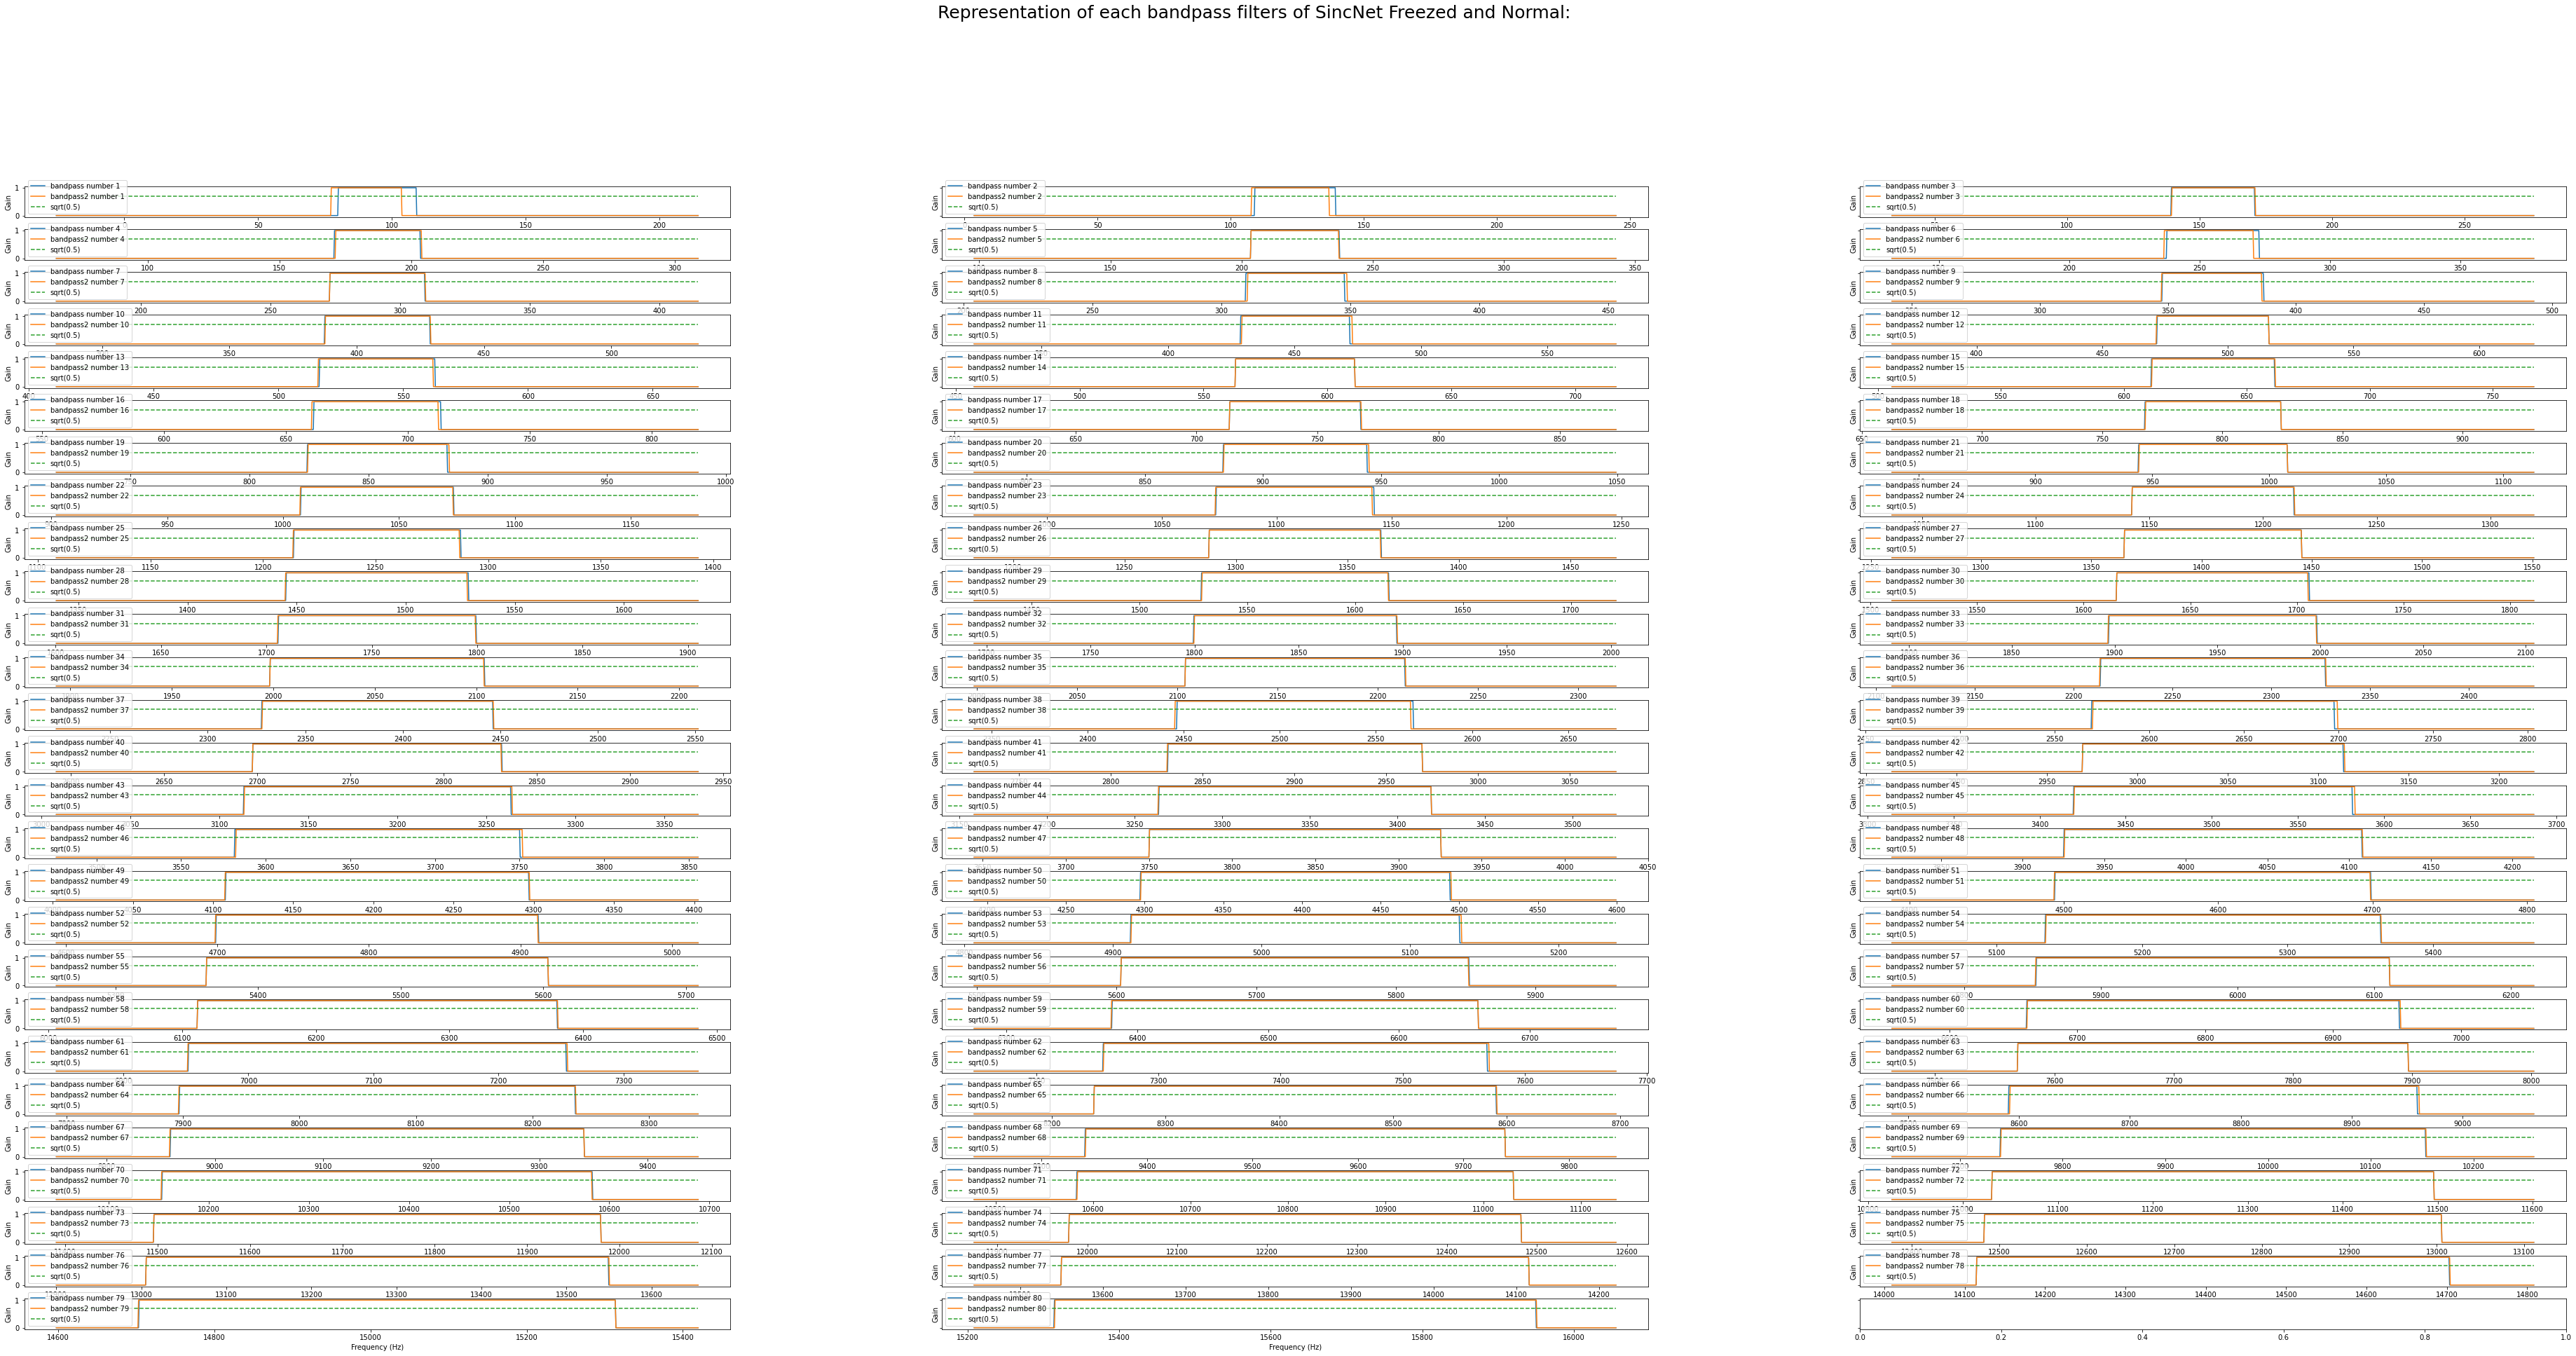

In [20]:
low_freq_2 = Main_net_normal.CNN_net.conv[0].min_low_hz + Main_net_normal.CNN_net.conv[0].low_hz_.cpu().detach().numpy()
high_freq_2 = low_freq_2 + Main_net_normal.CNN_net.conv[0].band_hz_.cpu().detach().numpy()

PlotFilters(low_freq, high_freq, "Freezed", low_freq_2, high_freq_2, "Normal")

#### c- Compare the results:

We can observe that there is a small difference between the values of the bandpass frequencies between the Freezed and Unfreezed networks. This difference has an impact on performances, the normal model performs better on training set, validation set and test set. Results wise it is useful to learn those parameters, it does not slow down the computation and adds a tad bit of precision.

##### Results on test dataset:
|                | Freezed | Normal |
|----------------|:-------:|:------:|
| Test loss      | 0.994   | 0.978  |
| Window acc     | 0.750   | 0.760  |
| best class acc | 0.819   | 0.831  |

##### Differences in training: 
However, despite Normal SincNet's better results on test dataset, we must keep in mind that training underwent differently for both networks. Thus, it is important to question the fact that unfreezing SincConv gives us better results.

|                           | Freezed  | Normal   |
|---------------------------|:--------:|:--------:|
| Validation loss           | 1.168097 | 1.139176 |
| Validation best class acc | 0.794    | 0.805    |
| Epochs                    | 165      | 235      |

##### Without SincConv_fast:
Freezing SincCinv_fast does not mean deactivating it, we still use it as it was initialized. An experiment that we can do is replacing SincConv_fast with a **1D convolutional** network and then compare their performances. Here are the results:

|                           | Without SincConv_Fast |
|---------------------------|:---------------------:|
| Validation loss           |         1.403         |
| Validation best class acc |         0.739         |
| Epochs                    |          135          |
| Test loss                 |         1.362         |
| Test best class acc       |         0.756         |


We can see that SincNet without its Sincs performs way worse with our best configuration. 
> See notebook **Net_Performance_Analysis**, section *Different activation function results, I.a.6* for more info.

#### d- Compare Spectrograms:

sampling rate = 32000. Please make sure the sampling rate is correct in order to get a valid freq range
STFT kernels created, time used = 0.0867 seconds


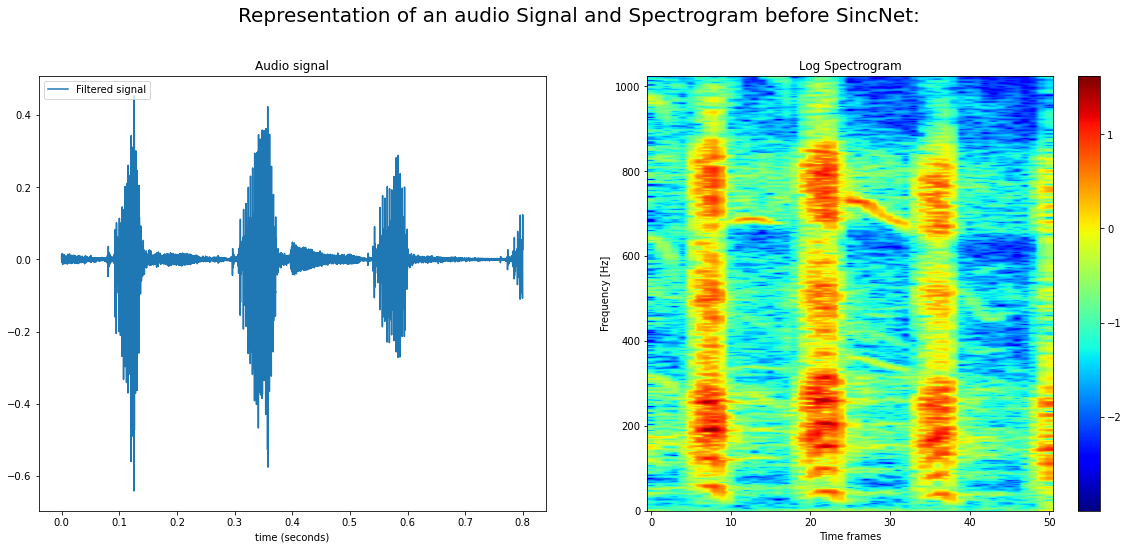

sampling rate = 32000. Please make sure the sampling rate is correct in order to get a valid freq range
STFT kernels created, time used = 0.0911 seconds


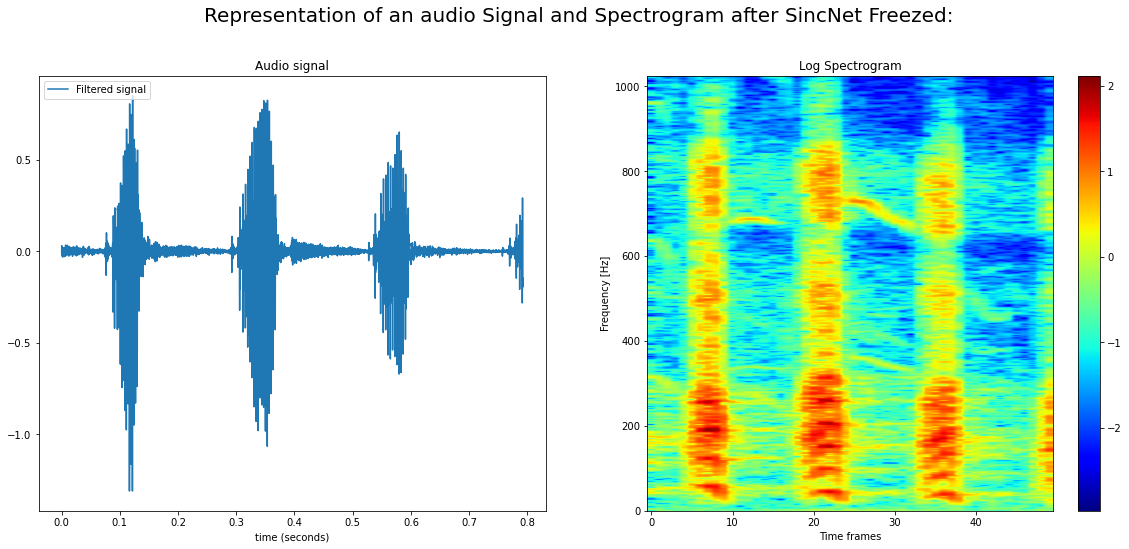

sampling rate = 32000. Please make sure the sampling rate is correct in order to get a valid freq range
STFT kernels created, time used = 0.0911 seconds


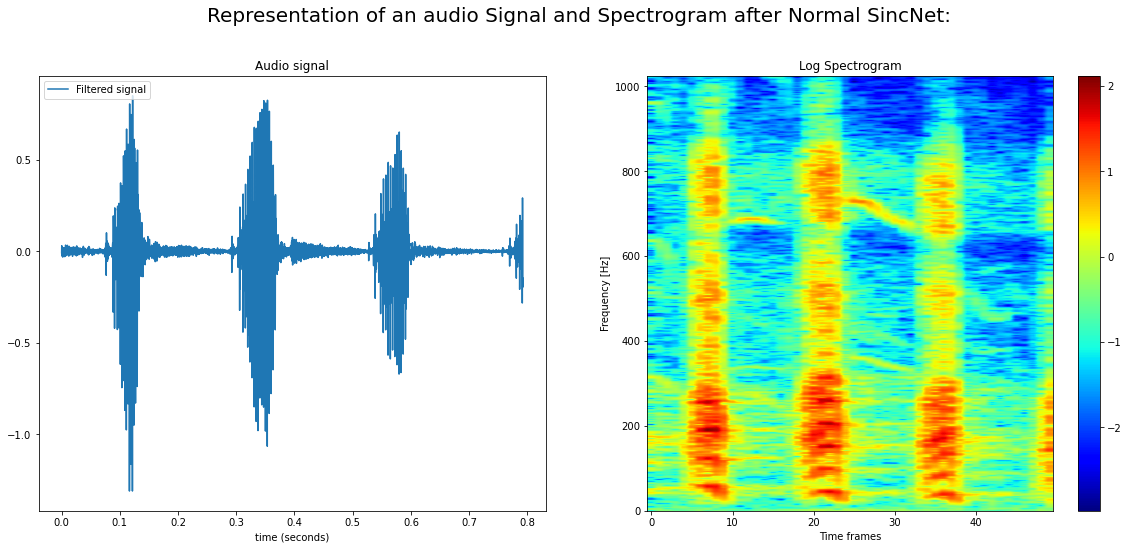

sampling rate = 32000. Please make sure the sampling rate is correct in order to get a valid freq range
STFT kernels created, time used = 0.0912 seconds


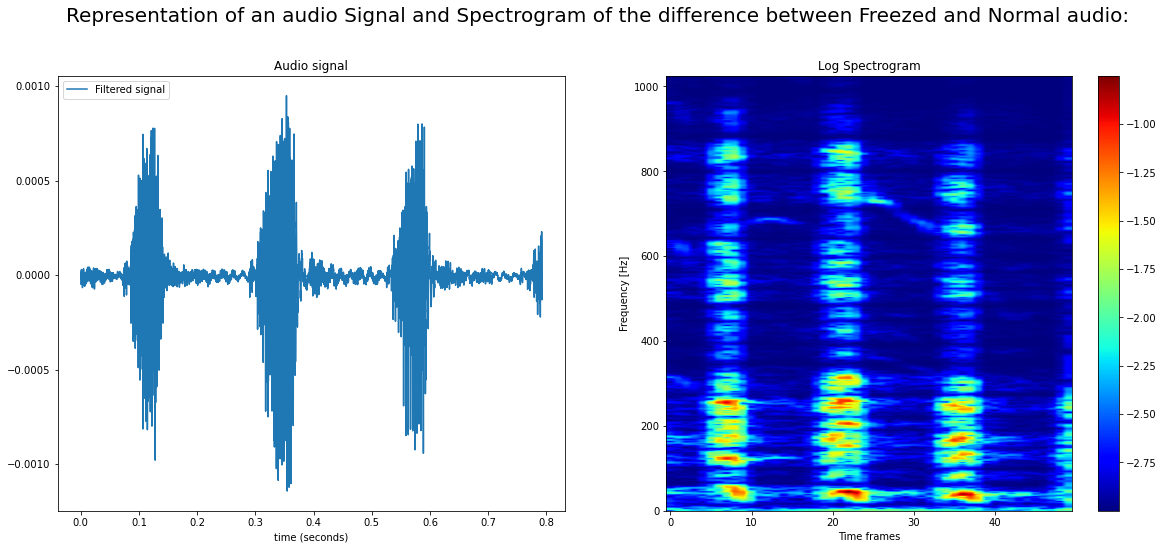

In [30]:
PrintAudioAndSpectrogram(audio_tensor.view(-1), "before SincNet", sampling_rate, is_Mel = False)

# Computing the audio part of signal:
audio_tensor_freezed_flat = FlatteningAudio(audio_tensor_freezed, mean = True)
audio_tensor_normal_flat  = FlatteningAudio(audio_tensor_normal, mean = True)
        
PrintAudioAndSpectrogram(audio_tensor_freezed_flat, "after SincNet Freezed", sampling_rate, is_Mel = False)
PrintAudioAndSpectrogram(audio_tensor_normal_flat, "after Normal SincNet", sampling_rate, is_Mel = False)

#PrintAudioAndSpectrogram(audio_tensor.view(-1) - audio_tensor_freezed_flat, "of the difference between Freezed and original audio", sampling_rate)
PrintAudioAndSpectrogram(audio_tensor_normal_flat - audio_tensor_freezed_flat, "of the difference between Freezed and Normal audio", sampling_rate, is_Mel = False)

## IV- Influence of learning bandpoass filters on SincNet2D: